# Maskinlæring

I denne notebooken skal vi 

- Bruke de nyvaskede og utforskede dataene våre til å trene en eller flere maskinlæringsmodeller.

- Se på hvordan vi kan måle kvaliteten til modellene våre, og hvordan vi kan øke kvalitet. 

- Se på hvordan vi kan kontrollere hvordan modellene våre oppfører seg basert på våre egne prioriteringer.



In [14]:
import pandas as pd

Først leser vi inn dataen vår fra en fil i parquet-format til en Pandas DataFrame:

In [2]:
df = pd.read_parquet("fraud_preprocessed.pq")

Denne parquet-filen skal du ha lagret fra den andre notebooken hvor du utforsket og vasket dataene. Den skal nå være klar til bruk i maskinlæringsmodellen(e) dine.

Hvis du ønsker kan du dobbelsjekke at alt ser ut til å være på plass slik du forventer, ved å bruke noen av de følgende pandas-funksjonene:

```
df.head()  # Se de første 5 radene
df.info()  # Se datatyper og hvor mange ikke-null verdier det er for hver kolonne
df.describe()  # Se statistisk fordeling av verdier i hver kolonne
for col in df:
    print(df[col].value_counts())  # Tell hvor mange ganger hver unike verdi forekommer
    print(str(len(df[col].unique())) + " unique values in column")
    print()
```

Når man trener en maskinlæringsmodell er det god praksis å sette tilside noe data som man ikke trener på, så man kan teste på den hvor godt modellen din generaliserer.

In [329]:
from sklearn.model_selection import train_test_split

y_col_name = "FraudFound_P"
y = df[y_col_name]
X = df.drop(y_col_name, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"FORDELING AV SVINDELSTILFELLER \ni testdata: \n{y_test.value_counts()}\ni treningsdata: \n{y_train.value_counts()}")

FORDELING AV SVINDELSTILFELLER 
i testdata: 
0    4782
1     307
Name: FraudFound_P, dtype: int64
i treningsdata: 
0    9715
1     616
Name: FraudFound_P, dtype: int64


Som så kan man splitte data i trening- og testset. Det er viktig at begge klassene er representert gjevnt i begge datasettene. 

La oss bruke dataene til å trene og teste en logistisk regressor, som er en av de mest grunnleggende og simple modellene for binær klassifisering:

In [398]:
logistic_regressor = LogisticRegression(solver='liblinear')
logistic_regressor = logistic_regressor.fit(X_train, y_train)
y_pred = logistic_regressor.predict(X_test) 

# performance
print('Accuracy Score: {}%'.format(round(accuracy_score(y_test, y_pred)*100, 1)))

Accuracy Score: 94.0%


94% riktig! Pack it up, our work here is done 😎

Eller?

Hva er egentlig nøyaktighet (accuracy), og hva er en "god" nøyaktighet?

Accuracy er hvor mange prosent av klassifikasjonene dine som ble riktig. Hvis du har et binært klassifiseringsproblem slik vi har her, og fordelingen mellom de to klassene ("muffins", "Ikke muffins") i dataen din er 6/94, så vil det å alltid gjette "ikke muffins" gi deg en nøyaktighet på 94%!

Vi bør ta to grep.

1. Vekte viktigheten av klassene våre, slik at de 6% svikstilfeller blir like viktige som de 94% ikke-svik
2. Bruke andre score-metrikker an accuracy

Her starter vi med en funksjon som viser deg litt flere kvalitetsmetrikker:

In [394]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def metrikker(model, X_test, y_test):
    # Muffinsmarkører som enten 0 eller 1
    y_pred = logistic_regressor.predict(X_test)
    # Muffinssansynligheter mellom 0 og 1
    y_pred_proba = pd.DataFrame(model.predict_proba(X_test), X_test.index, ["ikke", "muffins"])["muffins"]

    roc_auc = round(roc_auc_score(y_test, list(y_pred_proba)), 2)
    print('Accuracy Score: {}'.format(round(accuracy_score(y_test, y_pred), 2)))
    print('Area Under Curve: {}'.format(roc_auc))
    print('Recall score: {}'.format(recall_score(y_test, y_pred), 2))
    print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_pred), 2))

    # ROC Curve Display
    fpr, tpr, threshold = metrics.roc_curve(y_test, list(y_pred_proba))

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Og her bruker vi den funksjonen på den samme modellen vi nettop trente:

Accuracy Score: 0.94
Area Under Curve: 0.8
Recall score: 0.0
Confusion Matrix: 
[[4782    0]
 [ 307    0]]


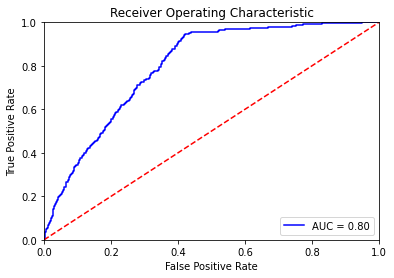

In [403]:
logistic_regressor = LogisticRegression(solver='liblinear')
logistic_regressor = logistic_regressor.fit(X_train, y_train)
metrikker(logistic_regressor, X_test, y_test)

En "confusion matrix" viser antall Type-1 og Type-2 feil, og antall riktige identifiserte tilfeller for begge klassene våre. I dette tilfellet viser confusion Matrix at ingen tilfeller har blitt klassifisert som muffins! Som vi ser kan man få ganske høy accuracy av å aldri gjette at det er noe muffins, men vi får 0.0 i Recall score (ingen korrekt klassifiserte svindelsaker) fordi ingen av muffinsprediksjonene våre var mer en 50% sikre på svindel. Så modellen slik den er konfigurert når man kaller "predict" sier ikke noen ting om svindlere!

**Klassene er ubalanserte**, og klassifiseringsgrensen i Sklearn (som ligger på 50% sansynlighet) er ikke er satt riktig for å bruke informasjonen i modellen på en måte som fokuserer på å identifisere svindlere korrekt.

**Hva er ROC?** En mer interessant måte man kan måle kvaliteten til en binær klassifikasjonsmodell som denne er hvordan True Positive Rate og False Positive Rate endrer seg i forhold til hverandre ettersom man flytter grenseverdien for å si at noe lukter muffins (en positiv prediksjon) opp eller ned. Det vil si, modellen gjør egentlig et sansynlighetsanslag mellom 0 og 100% på hvor sikker den er på at dette lukter muffins, og hvis du selv kan velge hvor mange prosent som skal til for at alarmen skal gå, så kan du gjøre en tradeoff mellom false positives og false negatives. I en businesscase vil man da gjøre et ansalg på langtidskostnaden av false positives versus langtidskostnaden av false negatives, og ta en runde på de etiske konsekvensene. Denne tradeoffen mellom true og false positives på forskjellige thresholds for en binær classifier kan plottes som en kurve, som vi kaller ROC-kurven (Receiver Operating Characteristic).

**Hvordan lese ROC-kurven:** Denne kurven viser at vi kan idendtifisere rundt 90% av svindeltilfellene, dersom vi også går med på at litt over 40% av uskyldige kunder blir markert som muffins. Hvis vi vil halvere antallet markerte uskyldige kunder til 20%, får vi bare markert rundt 55% av svindlerne. Det er uansett tydelig at vi må akseptere en del falske positiver hvis vi vil greie å identifisere svikerne, som vil legge en begrensning på hvordan vi kan bruke modellen forretningsmessig.

### Vi fikser feilene våre

Hvis vi sjekker hvor mange prosent svindel det er i datasettet vårt kan vi lage en vekting til regressoren vår bassert på dét!

Accuracy Score: 0.62
Area Under Curve: 0.8
Recall score: 0.8827361563517915
Confusion Matrix: 
[[2895 1887]
 [  36  271]]


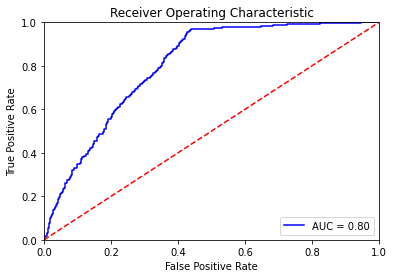

In [406]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, roc_curve

# Vekting av klassene
svindel_prosent = float(float(100*y_train.value_counts()[1])/len(y_train))
w = {0:svindel_prosent, 1:(100-svindel_prosent)} # Vekting av viktighet etter prosentandel representasjon i datasettet

logistic_regressor = LogisticRegression(solver='liblinear', class_weight=w)
logistic_regressor = logistic_regressor.fit(X_train, y_train)

metrikker(logistic_regressor, X_test, y_test)

## 🚀🧠 Se på recall score og confusion matrix!

Vi identifiserer nå de fleste svikstilfellene riktig, slik den første ROC-kurven viste at vi kunne dersom vi gjorde den riktige trade-offen.

La oss ta en titt på hvordan muffinsprediksjoner for påviste svindlere sammenliges med resten!

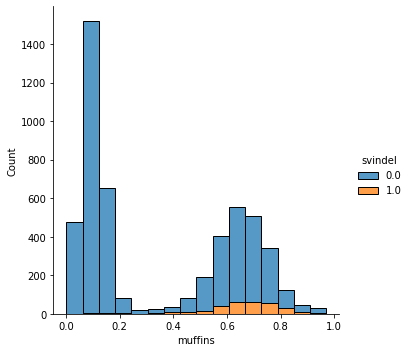

In [420]:
import seaborn as sns
combined = pd.DataFrame([y_pred_proba, y_test]).T
combined.columns = ["muffins", "svindel"]
sns.displot(data=combined, x="muffins", hue="svindel", multiple="stack")

Det er fint å se at svindlere stort sett får høy score, selv om mange som vi ikke vet at er skyldige også blir misstenkt. Det stemmer over ens med forventningene våre fra å se på ROC-kurven

## Kryssvalidering

Nå har vi trent og testet på én splitt, men det kan være at akkurat denne splitten forårsaker unøyaktig trening eller test på grunn av arbitrære mønstre eller støy i dataen som ikke er representative for dataen som helhet. Hvis man ønsker seg et godt mål på hvor bra treningsregimet ditt og modellen din er egnet til dataen kan det lønne seg å splitte på flere forskjellige måter, og sammenligne scorene dine fra å trene og teste på forskjellige splitter.

En metode for dette kalles K-fold cross-validation. Navnet lyder slik fordi man folder dataen i K deler, og for hver av de K delene trener man først på all dataen som ikke er i delen, og så tester man på den delen. Størrelsen på K avgjør også størrelsen på test-settene, som får størrelsen 1/K. K bør være høy nok til at treningssettet inneholder et representativt utvalg av dataen i alle tilfeller, men des høyere K er des mindre representativt for populasjonen vil testfolden være.

Klassen StratifiedKFold sørger for at alle testfoldene skal ha sirka like mange svindelforsøk, og alle treningsfoldene skal ha like mange svindelforsøk.

In [426]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
 
k = 5
k_fold_x_validation = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

accuracy_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="accuracy")
print("Avg accuracy: {}".format(round(accuracy_cv.mean(), 3)))
print(f"accuracy for alle folder: {accuracy_cv}")
roc_auc_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="roc_auc")
print("Avg roc_auc: {}".format(round(roc_auc_cv.mean(), 3)))
print(f"roc auc for alle folder: {roc_auc_cv}")
accuracy_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="recall")
print("Avg recall: {}".format(round(accuracy_cv.mean(), 3)))
print(f"recall for alle folder: {accuracy_cv}")

Avg accuracy: 0.61
accuracy for alle folder: [0.60927367 0.61608301 0.61478599 0.59338521 0.61413748]
Avg roc_auc: 0.79
roc auc for alle folder: [0.78334145 0.79040105 0.79191147 0.81300728 0.7707765 ]
Avg recall: 0.902
recall for alle folder: [0.86413043 0.9076087  0.92432432 0.95135135 0.86486486]


Her kan vi se at det er litt variasjon hver gang modellen trenes, fordi den konvergerer forskjellig når den trener på forskjellig data.

La oss se hvordan ROC-kurven varierer mellom forskjellige treningsfolder:

In [431]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

def cv_roc_curve(classifier, X, y):
    cv = StratifiedKFold(n_splits=6)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Gjennomsnitlig ROC-kurve med variabilitet",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

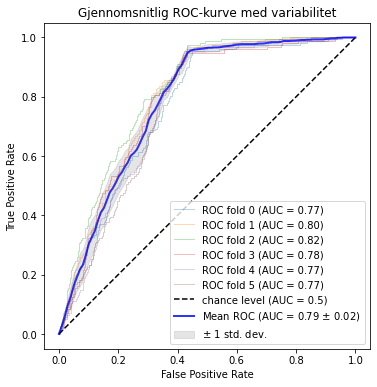

In [432]:
cv_roc_curve(logistic_regressor, X, y)

Vi ser at modellen vår er ganske robust, men har litt variasjon mellom treningsfoldene, som er naturlig. Hvis dataen er veldig stor, uniform, og uten outliers, vil det være lite variasjon mellom foldene. Hvis dataen er liten, ugjevn, og har mange outliere vil det være stor variasjon mellom foldene.